Intro, what is GRAF, why NASLib wrapper, main features

In [ ]:
"""
# clone a NASLib fork that supports python 3.11
!git clone -b automl-conf-24 --single-branch git@github.com:gabikadlecova/NASLib.git

# install NASLib
%cd NASLib
%pip install -e .
# %pip install ConfigSpace==0.6 --quiet
%cd ..
"""

# download dataset apis and NAS-Bench-Suite Zero data
"""
%cd /content/NASLib
!source scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
# !source scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
# !source scripts/bash_scripts/download_benchmarks.sh nb201 ImageNet16-120
# !source scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
# !source scripts/zc/bash_scripts/download_nbs_zero.sh nb101
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201
# !source scripts/zc/bash_scripts/download_nbs_zero.sh nb301
"""

In [ ]:
"""
!git clone git@github.com:gabikadlecova/GRAF.git
%cd GRAF
%pip install -e .
%cd ..
"""

In [46]:
# ------ Setup ------ #
benchmark = 'nb201'
dataset = 'cifar10'

feature_cfg = '../graf_nas/configs/nb201.json'

naslib_path = '../../zero_cost/NASLib'

# 0. Introduction to the GRAF library

Enables computation of zero-cost proxies, working with the neural graph etc

Wrapper round NASLib, but extensible to user defined search spaces and zero-cost proxies. No support for GNN input encoding etc. - NASLib
is still more powerful (this is just to enable easy analysis of ZCP and integration with other systems)

Easy integration with simple performance predictors.

## Search spaces

In [1]:
from graf_nas.search_space import NB201

net = '(2, 0, 0, 2, 0, 2)'  # a network with 3 sequential 3x3 conv-bn-relu, and skip-connections between them

# unified representation of architectures from a search space
network = NB201(net, cache_model=True)
print("Network: ", network.net)

# the network can be converted to a graph
graph = network.to_graph()
print("Edges: ", graph.edges)
print("Ops: ", graph.ops)
print("Networkx graph: ", graph.to_graph())


Network:  (2, 0, 0, 2, 0, 2)
Edges:  {(1, 2): 2, (1, 3): 0, (1, 4): 0, (2, 3): 2, (2, 4): 0, (3, 4): 2}
Ops:  {0: 'skip_connect', 1: 'none', 2: 'nor_conv_3x3', 3: 'nor_conv_1x1', 4: 'avg_pool_3x3'}
Networkx graph:  DiGraph with 4 nodes and 6 edges


In [2]:
import torch

# you can convert the network to a parsed NASLib object
model = network.get_model()
print(model)

# it is a PyTorch model
print("Is it torch.nn.Module: ", isinstance(model, torch.nn.Module))

model(torch.randn(1, 3, 32, 32))  # you can directly pass data to the model

NasBench201SearchSpace named 'makrograph' with 20 nodes and 19 edges
Is it torch.nn.Module:  True


tensor([[-0.0026, -0.0248,  0.1126,  0.1976, -0.1839, -0.0226,  0.1574,  0.2459,
          0.2547, -0.0132]], grad_fn=<AddmmBackward0>)

In [ ]:
from graf_nas.search_space import searchspace_classes, dataset_api_maps
from naslib.utils import get_dataset_api

# you can also get the NB201 class by indexing the searchspace_classes dictionary
net_cls = searchspace_classes[benchmark]

# the class itself supports iterating over all architectures in the search space (you need to download NASLib dataset api - done at the start of the doc)
dataset_api = get_dataset_api(search_space=dataset_api_maps[benchmark], dataset=dataset)
net_iterator = net_cls.get_arch_iterator(dataset_api)

next(iter(net_iterator)).net

'(0, 0, 0, 0, 0, 0)'

## Zero-cost proxies

In [5]:
# GRAF support easy computation of all zero-cost proxies in NAS-Bench-Suite Zero (and also extension with new ones)
import os
from graf_nas.features.zero_cost import get_zcp_predictor, get_zcp_dataloader, available_measures

print('Available NASLib zero-cost proxies: ', available_measures)

# You need to download the data loader for ZCP computation
dataloader = get_zcp_dataloader(dataset=dataset, zc_cfg=os.path.join(naslib_path, 'naslib/runners/zc/zc_config.yaml'), data=naslib_path)

# You can get a predictor for a specific zero-cost proxy
predictor = get_zcp_predictor('synflow', dataloader=dataloader)
print(predictor)

# using the PyTorch model from previous cells, compute the synflow score! (you might want to change to the GPU runtime)
print(predictor(model))

Available NASLib zero-cost proxies:  ['grad_norm', 'snip', 'grasp', 'fisher', 'jacov', 'plain', 'synflow_bn', 'synflow', 'epe_nas', 'zen', 'l2_norm', 'nwot']
Files already downloaded and verified
Files already downloaded and verified
synflow
111.84541218759227


## Neural Graph features

In [4]:
import json
import pprint

# represented by a config
with open(feature_cfg, 'r') as f:
    cfg = json.load(f)

# This config contains 4 features - operation counts, min path length, max path length, and node degrees
pprint.pprint(cfg, sort_dicts=False)

[{'name': 'op_count'},
 {'name': 'min_path_len',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']},
 {'name': 'max_op_on_path',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']},
 {'name': 'node_degree',
  'allowed': ['skip_connect',
              'none',
              'nor_conv_3x3',
              'nor_conv_1x1',
              'avg_pool_3x3']}]


In [5]:
from graf_nas.features.config import load_from_config

# the features from the config are loaded as a list of objects
features = load_from_config(cfg, benchmark)
print(features[:2])
print()

# these represent graf features limited to a subset of the operation set
print([str(f) for f in features[:10:2]])

[<graf_nas.features.base.Feature object at 0x7f9db5634310>, <graf_nas.features.base.ConstrainedFeature object at 0x7f9c9c3eb150>]

['op_count', 'min_path_len_(none)', 'min_path_len_(nor_conv_1x1)', 'min_path_len_(skip_connect,none)', 'min_path_len_(skip_connect,nor_conv_1x1)']


In [6]:
some_feat = features[1]

print(f"Computing {some_feat} for the following network:")
print({k: graph.ops[v] for k, v in graph.edges.items()})
print()

print("Result: ", some_feat(graph))  # you can compute the features for a network graph

Computing min_path_len_(skip_connect) for the following network:
{(1, 2): 'nor_conv_3x3', (1, 3): 'skip_connect', (1, 4): 'skip_connect', (2, 3): 'nor_conv_3x3', (2, 4): 'skip_connect', (3, 4): 'nor_conv_3x3'}

Result:  1


# 1. Zero-cost proxy biases

In [47]:
import json
import os
from graf_nas.features.zero_cost import parse_scores

# load NAS-Bench-Suite Zero data for NB201
with open(os.path.join(naslib_path, 'naslib/data/zc_nasbench201.json'), 'r') as f:
    zc_data = json.load(f)

# convert it to DataFrame for easier analysis of the whole search space
zc_dataframe = parse_scores(zc_data, dataset)

In [21]:
from graf_nas.search_space.reduntant import remove_zero_branches

# the NB201 benchmark contains networks with unreachable operations due to zero ops
# let's remove them - they skew the zero-cost proxy analysis
new_index = []
zero_op = 1

for net in zc_dataframe.index:
    graph = NB201(net).to_graph()
    
    # skip if networks contains unreachable operations - this function zeroed them out
    new_graph = remove_zero_branches(graph, zero_op=zero_op)
    if new_graph.edges != graph.edges:
        continue

    new_index.append(net)

print('Before removal: ', len(zc_dataframe))
zc_dataframe = zc_dataframe.loc[new_index].copy()
print('After removal: ', len(zc_dataframe))

Before removal:  15625
After removal:  9445


In [22]:
zc_dataframe.head()

,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen
net,,,,,,,,,,,,,,
"(4, 0, 3, 1, 4, 3)",84.99,1283.299108,0.036440,19.248832,10.883215,0.244735,-88.289871,130.200516,754.684333,0.129306,0.033875,22.923178,44.484811,63.387894
"(2, 4, 0, 0, 3, 2)",90.52,1712.860614,0.023383,85.235392,12.691692,2.205327,-65.193310,180.487396,785.622961,0.587386,0.079539,26.610859,85.295247,119.493332
"(0, 0, 2, 1, 2, 3)",88.32,1892.558689,0.091167,83.945152,24.872454,12.207823,-65.285305,180.934311,788.917398,0.587386,0.077502,51.889561,60.212156,92.669968
"(4, 1, 3, 3, 3, 3)",87.35,1379.897450,0.161322,26.683072,41.271332,23.266205,-78.714333,231.918152,803.910385,0.185306,0.159051,68.328522,55.762511,66.955254
"(3, 1, 2, 3, 2, 3)",88.94,1591.668318,2.919859,92.669632,194.829361,352.838989,-65.193801,283.023499,820.626852,0.643386,0.146713,300.757782,76.735830,103.120293


Let's plot NASWOT (denoted `nwot`) against validation accuracy

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# ylims per proxy (each has different score ranges and outliers)
ylims = {'nwot': (550, 850)}

def plt_ylim(prox):
    if prox not in ylims:
        return
    plt.ylim(ylims[prox][0], ylims[prox][1])

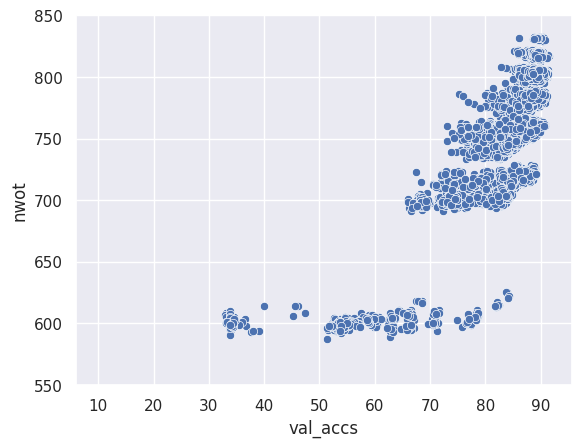

In [24]:
proxy = 'nwot'

sns.scatterplot(data=zc_dataframe, x='val_accs', y=proxy)
#plt.xlim(70, 91)
plt_ylim(proxy)
plt.show()

You can see some clusters forming. We could look at networks from the bottom cluster:

In [25]:
op_map = NB201.get_op_map()
print("The meaning of numbers: ", op_map)

nwot_cluster = zc_dataframe[zc_dataframe[proxy] < 650]
nwot_cluster.index[:6].to_list()

The meaning of numbers:  {'skip_connect': 0, 'none': 1, 'nor_conv_3x3': 2, 'nor_conv_1x1': 3, 'avg_pool_3x3': 4}


['(4, 0, 0, 4, 4, 4)',
 '(4, 0, 4, 0, 0, 0)',
 '(4, 0, 1, 0, 1, 4)',
 '(4, 4, 1, 4, 4, 4)',
 '(4, 4, 0, 1, 4, 4)',
 '(0, 4, 4, 4, 0, 0)']

Seems like there is are no convolutions in the network... Let's compute the number of convs via GRAF and mark the clusters:

In [26]:
import pandas as pd

n_convs = []
op_count_func = features[0]  # run the cells in section 0 for this to work

for net in zc_dataframe.index:
    op_counts = op_count_func(NB201(net).to_graph())
    
    conv_1_id, conv_3_id = op_map['nor_conv_1x1'], op_map['nor_conv_3x3']
    n_convs.append(op_counts[conv_1_id] + op_counts[conv_3_id])

zc_dataframe['n_convs'] = n_convs
zc_dataframe['n_convs'] = pd.Categorical(zc_dataframe['n_convs'])

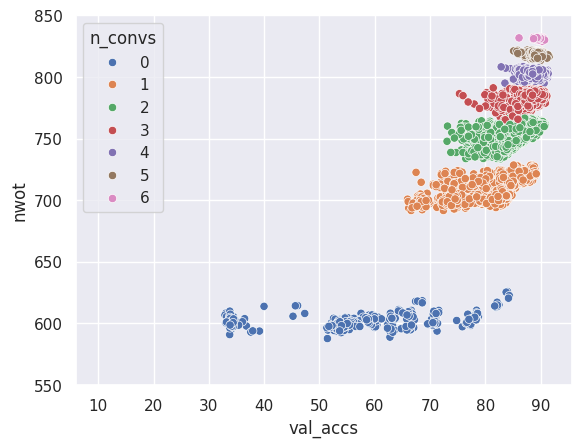

In [27]:
sns.scatterplot(data=zc_dataframe, x='val_accs', y=proxy, hue='n_convs')
#plt.xlim(70, 91)
plt_ylim(proxy)
plt.show()

Uh-oh, seems like `nwot` has a high dependency on the number of convolutions! If you analyze the clusters further (exercise), you see that the scores in the clusters also depend on the number of `conv3x3`

In [30]:
# ----- optional exercise -----
# Analyze one of the clusters (e.g. the one with 3 convolutions)

# a) filter DataFrame to get only nets with 3 convs
# b) create a column - n_convs_3x3 (use op_counts again)
# c) plot the clusters with hue set to n_cobvs_3x3

# **** your code ****
pass

Disclaimer: this happens mostly in NB201, the effect in NB101 is lower, and DARTS does not seem to be affected.

Nevertheless, the proxies have the highest score on NB201, and for some of them, these biases are one of the reasons. In other words, both `val_accs` and `nwot` correlate with the number of convolutions.

### Exercise - plot other proxies / analyze other benchmarks

Choose one of the proxies in the dataframe and analyze its relationship to operation count (or perhaps other features).

You can also set `benchmark = 'nb101'` and `feature_cfg = graf_nas/configs/nb101.json` and analyze a different search space. The code for downloading `zc_nasbench101.json` is at the top of the notebook (it was commented out to save waiting time).

In [ ]:
from graf_nas.search_space import DARTS, NB101

# **** your code ****
pass

# 2. Performance prediction via GRAF

## GRAF - easy computation of ZCP and features

In [7]:
from graf_nas.graf import GRAF
zcp_names = ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']

# GRAF unifies computation of features and zero-cost proxies
graf_model = GRAF(benchmark,
                  features=features,  # either a list of features, or a path to the config file
                  zcp_predictors=zcp_names,  # a list of zero-cost proxy names or predictor objects
                  cached_data=zc_dataframe,  # you can use data from NB Suite Zero to avoid ZCP computation
                  cache_features=True)  # cache computed features from GRAF

In [13]:
feats = graf_model.compute_features(network)  # compute features for a network

i = 0
for k, v in feats.items():
    print(f"{k}: {v}")
    i += 1
    if i > 7:
        print('...')
        break

op_count_0: 3
op_count_1: 0
op_count_2: 3
op_count_3: 0
op_count_4: 0
min_path_len_(skip_connect): 1
min_path_len_(none): 6
min_path_len_(nor_conv_3x3): 3
...


In [14]:
graf_model.compute_zcp_scores(network)

{'epe_nas': 1657.737740511819,
 'fisher': 0.009487888775765896,
 'flops': 115.402432,
 'grad_norm': 9.60776424407959,
 'grasp': 0.19346094131469727,
 'jacov': -65.20240181876179,
 'l2_norm': 180.5452880859375,
 'nwot': 785.0347715480094,
 'params': 0.802426,
 'plain': 0.1098535805940628,
 'snip': 18.618627548217773,
 'synflow': 111.92830625120547,
 'zen': 139.31690979003906}

In [8]:
from graf_nas.graf import create_dataset

# graf_nas contains a helper function for creating a tabular dataset:
use_onehot = False
use_zcp = True
use_features = True
target = 'val_accs'

# you need a net iterator - we will use the index from NB Suite Zero
net_iterator = (NB201(n) for n in zc_dataframe.index.to_list())

# alternatively, use the iterators with NASLib dataset api
# net_iterator = NB201.get_arch_iterator(dataset_api)

feature_dataset, y = create_dataset(graf_model, net_iterator,
                                    target_df=zc_dataframe, target_name=target,  # dataframe with the target column (optional)
                                    use_features=use_features, use_zcp=use_zcp, use_onehot=use_onehot,  # which encodings to use
                                    drop_unreachables=benchmark == 'nb201')  # search space with zero ops

16it [00:00, 70.37it/s]

15625it [02:42, 96.33it/s] 


In [10]:
# full set of features for the networks
pprint.pprint(feature_dataset.head())

                    op_count_0  op_count_1  op_count_2  op_count_3  op_count_4  min_path_len_(skip_connect)  min_path_len_(none)  min_path_len_(nor_conv_3x3)  min_path_len_(nor_conv_1x1)  min_path_len_(avg_pool_3x3)  min_path_len_(skip_connect,none)  min_path_len_(skip_connect,nor_conv_3x3)  min_path_len_(skip_connect,nor_conv_1x1)  min_path_len_(skip_connect,avg_pool_3x3)  min_path_len_(none,nor_conv_3x3)  min_path_len_(none,nor_conv_1x1)  min_path_len_(none,avg_pool_3x3)  min_path_len_(nor_conv_3x3,nor_conv_1x1)  min_path_len_(nor_conv_3x3,avg_pool_3x3)  min_path_len_(nor_conv_1x1,avg_pool_3x3)  min_path_len_(skip_connect,none,nor_conv_3x3)  min_path_len_(skip_connect,none,nor_conv_1x1)  min_path_len_(skip_connect,none,avg_pool_3x3)  min_path_len_(skip_connect,nor_conv_3x3,nor_conv_1x1)  min_path_len_(skip_connect,nor_conv_3x3,avg_pool_3x3)  min_path_len_(skip_connect,nor_conv_1x1,avg_pool_3x3)  min_path_len_(none,nor_conv_3x3,nor_conv_1x1)  \
(4, 0, 3, 1, 4, 3)           1          

## Train a performance predictor

In [11]:
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import r2_score, mean_squared_error

def get_train_test_splits(feature_dataset, y, train_size, seed):
    train_X, test_X, train_y, test_y = train_test_split(feature_dataset, y, train_size=train_size, random_state=seed)
    return {'train_X': train_X, 'train_y': train_y, 'test_X': test_X, 'test_y': test_y}


def eval_model(model, data_splits):
    start = time.time()
    model.fit(data_splits['train_X'], data_splits['train_y'])
    fit_time = time.time() - start

    preds = model.predict(data_splits['test_X'])
    true = data_splits['test_y']

    res = {
        'fit_time': fit_time,
        'r2': r2_score(true, preds),
        'mse': mean_squared_error(true, preds),
        'corr': spearmanr(preds, true)[0],
        'tau': kendalltau(preds, true)[0]
    }

    return res

In [13]:
seed = 42
n_evals = 50
train_size = 100

# we use the Random Forest, because it's fast to fit. In practice, you would use a tuned XGBoost or a tabular AutoML system
rf = RandomForestRegressor()

data_splits = get_train_test_splits(feature_dataset, y, train_size, seed)
res = eval_model(rf, data_splits)

print(res)

{'fit_time': 0.4751884937286377, 'r2': 0.6042614113474791, 'mse': 18.67546095691381, 'corr': 0.9140756208774302, 'tau': 0.7443707437594393}


In [17]:
# ideally, evaluate the model multiple times and report the mean/std ...
import pandas as pd


results = []
for i in range(n_evals):
    data_seed = seed + i
    data_splits = get_train_test_splits(feature_dataset, y, train_size, data_seed)
    
    rf = RandomForestRegressor()

    res = eval_model(rf, data_splits)
    res['seed'] = data_seed
    results.append(res)

res_df = pd.DataFrame(results)
print(res_df.mean())

fit_time     0.375859
r2           0.743025
mse         12.092550
corr         0.926532
tau          0.767057
seed        66.500000
dtype: float64


# 3. Interpretability via SHAP

In [18]:
import numpy as np
import shap

# function for computing the shapley values
def shap_importances(model, test_X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test_X)
    shap_values = np.abs(shap_values).mean(axis=0)
    return shap_values

In [20]:
shapvals = shap_importances(rf, data_splits['test_X'])

In [24]:
# shapley values match the number of data columns
feature_names = data_splits['test_X'].columns
len(shapvals), len(feature_names)

(204, 204)

In [25]:
importances = pd.DataFrame({'name': feature_names, 'shap': shapvals})
importances.head()

,name,shap
0,op_count_0,0.002082
1,op_count_1,0.008196
2,op_count_2,0.014873
3,op_count_3,0.001956
4,op_count_4,0.006066


In [30]:
# get the most important features according to shap

importances.sort_values('shap', ascending=False)[:10]

,name,shap
191,epe_nas,1.915670
196,jacov,0.594716
198,nwot,0.491787
194,grad_norm,0.149341
114,"node_degree_(none,avg_pool_3x3)_avg_out",0.130905
197,l2_norm,0.123606
113,"node_degree_(none,avg_pool_3x3)_avg_in",0.111720
137,"node_degree_(skip_connect,none,avg_pool_3x3)_a...",0.111578
141,"node_degree_(skip_connect,nor_conv_3x3,nor_con...",0.111196
203,zen,0.102282


### Exercise -- look at importances when using only the features
Using `create_dataset`, create a new input dataset. Then, train a new predictor and analyze the importances. You can also experiment with different predictors.

Alternatively, compare the `cifar10` importances with the `cifar100` and `ImageNet16-120` datasets (requires loading a different dataset from `zc_nasbench201.json`)

In [31]:
# **** your code ****
pass

# 4. Extending the GRAF library

## New ZCP (TODO)

You can look at zero-cost proxy code in NASLib: https://github.com/automl/NASLib/tree/Develop/naslib/predictors/utils/pruners/measures

Zero-cost proxies in NASLib are mostly adapted from https://github.com/SamsungLabs/zero-cost-nas/tree/main/foresight/pruners/measures

In [100]:
def is_conv3x3(module):
    return isinstance(module, torch.nn.Conv2d) and str(module.kernel_size) == '(3, 3)'

# get all the convs3x3
[name for name, module in model.named_modules() if is_conv3x3(module)][:5]

['makrograph-edge(1,2).seq.0',
 'makrograph-edge(2,3).cell-edge(1,2).op.1',
 'makrograph-edge(2,3).cell-edge(2,3).op.1',
 'makrograph-edge(2,3).cell-edge(3,4).op.1',
 'makrograph-edge(3,4).cell-edge(1,2).op.1']

In [101]:
# proxy function
def compute_conv3x3_params(net):
    def is_conv3x3(module):
        return isinstance(module, torch.nn.Conv2d) and str(module.kernel_size) == '(3, 3)'

    conv_params = 0
    for _, module in net.named_modules():
        if not is_conv3x3(module):
            continue
        conv_params += sum([p.flatten().shape[0] for p in module.parameters()])

    return conv_params / 1e6  # params in NB-Suite-Zero are actually megaparams

In [102]:
from graf_nas.features.zero_cost import ZeroCostFunc

scorer = ZeroCostFunc('conv3x3_params', compute_conv3x3_params)
print(f"{scorer.name}: ", scorer(network.get_model()), " | params: ", zc_dataframe.loc[network.net]['params'])

conv3x3_params:  0.795312  | params:  0.802426
